In [1]:
from brian2 import *
from scipy.stats import pearsonr
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

%matplotlib inline

run_time = 10 * second
sizes = [1000, 1000, 1000] # Population of I Neurons
connect = [0.4, 0.2, 0.1] # Connectivity
ext_drive = [5, 10, 15, 20, 25, 30] # External drive

output_spike = []
output_LFP = []

for x in np.arange(0, len(sizes)):
    N = sizes[x]
    p_con = connect[x]
    for drive in ext_drive:
        N_E = int(N * 0)  # pyramidal neurons
        N_I = int(N * 1)  # interneurons

        # voltage
        V_L = -70. * mV # Resting potential
        V_thr = -52. * mV  # Threshold for firing
        V_reset = -59. * mV  # Resest voltage
        V_E = 0 * mV  # Reversal potential excitatory
        V_I = -70. * mV  # Reversal potential inhibitory

        # refractory period
        tau_E = 2. * ms
        tau_I = 1. * ms

        # external stimuli  
        C_ext = 800  # Number of inputs
        dext = drive * 1000
        total_input = int(dext / C_ext)
        rate = total_input * Hz

        # Membrane time constants for I and E
        tau_m_I = 10 * ms
        tau_m_E = 20 * ms

        # Conductances, I
        g_GABA_I = 4 * nS #4
        g_AMPA_I = 0.3 * nS # 0.3
        g_NMDA_I = 0.1 * nS
        g_AMPA_ext_I = 1.2 * nS

        # Conductances, E
        g_GABA_E = 2.5 * nS
        g_AMPA_E = 0.19 * nS
        g_NMDA_E = 0.06 * nS

        # Time constants for GABA
        tau_d_GABA = 5 * ms
        tau_r_GABA = 0.5 * ms
        tau_l_GABA = 1 * ms

        # Time constants for poisson inputs
        tau_d_Ext = 2 * ms
        tau_r_Ext = 0.5 * ms
        tau_l_Ext = 1 * ms

        # Time constants for AMPA
        tau_d_AMPA = 2 * ms
        tau_r_AMPA = 0.5 * ms
        tau_l_AMPA = 1 * ms

        # Time constants for NMDA
        tau_d_NMDA = 100 * ms
        tau_r_NMDA = 2 * ms
        tau_l_NMDA = 1 * ms

        # Conductance and Membrane Leak (for correct units)
        c_m_I = 0.2 * nF #0.2 * nF
        g_m_I = 20 * nS #20. * nS
        c_m_E = 0.5 * nF #0.5 * nF
        g_m_E = 25 * nS #25. * nS

        # Playing with constants
        g_AMPA_ext_I = g_AMPA_ext_I * 1
        g_GABA_I = g_AMPA_ext_I * 1 
        c_m_I = c_m_I * 1
        g_m_I = g_m_I * 1

        eqs_I = '''
        dv/dt = (-g_m_I * (v - V_L) - I_syn) / c_m_I : volt 

        I_syn = I_Ext + I_GABA: amp 

        I_GABA =  g_GABA_I * (v - V_I) * s_GABA : amp
        I_Ext =  g_AMPA_ext_I * (v - V_E) * s_Ext : amp

        ds_GABA/dt = ((tau_r_GABA / tau_d_GABA) ** \
                     (tau_d_GABA / (tau_r_GABA - tau_d_GABA))*c_g-s_GABA)/tau_d_GABA : 1
        dc_g/dt = -c_g/tau_r_GABA : 1

        ds_Ext/dt = ((tau_r_Ext / tau_d_Ext) ** 
                     (tau_d_Ext / (tau_r_Ext - tau_d_Ext))*c_p-s_Ext)/tau_d_Ext : 1
        dc_p/dt = -c_p/tau_r_Ext : 1
        '''

        P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_I, method='euler')

        pre_GABA = '''
        c_g += 1
        '''

        C_P_R = PoissonInput(P_I, 'c_p', C_ext, rate, '1')
        P_I.v = V_L
        C_I_I = Synapses(P_I, P_I, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
        C_I_I.connect(condition='i != j', p=p_con)


        s_I = SpikeMonitor(P_I)
        #M = StateMonitor(P_I, ('v', 'I_GABA_t', 'I_Ext'), record=True)
        p_I = PopulationRateMonitor(P_I)

        net = Network(P_I, C_P_R, C_I_I, s_I, p_I)
        net.run(run_time, report='stdout')

        output_spike.append(s_I)
        output_LFP.append(p_I)

Starting simulation at t=0. s for a duration of 10. s
4.6349 (46%) simulated in 10s, estimated 12s remaining.
9.7565 (97%) simulated in 20s, estimated < 1s remaining.
10.0 (100%) simulated in 20s
Starting simulation at t=0. s for a duration of 10. s
4.7741 (47%) simulated in 10s, estimated 11s remaining.
9.6988 (96%) simulated in 20s, estimated 1s remaining.
10.0 (100%) simulated in 20s
Starting simulation at t=0. s for a duration of 10. s
4.5921 (45%) simulated in 10s, estimated 12s remaining.
9.257 (92%) simulated in 20s, estimated 2s remaining.
10.0 (100%) simulated in 21s
Starting simulation at t=0. s for a duration of 10. s
4.2845 (42%) simulated in 10s, estimated 13s remaining.
8.530100000000001 (85%) simulated in 20s, estimated 3s remaining.
10.0 (100%) simulated in 23s
Starting simulation at t=0. s for a duration of 10. s
4.0642000000000005 (40%) simulated in 10s, estimated 15s remaining.
8.1471 (81%) simulated in 20s, estimated 5s remaining.
10.0 (100%) simulated in 24s
Starti

In [2]:
#run_time = 10 * second
#sizes = [500, 1000, 2000] # Population of I Neurons
#p_con = [0.4, 0.2, 0.1] # Connectivity
#ext_drive = [5, 10, 15, 20, 25, 30] # External drive
bins = np.arange(250, run_time/ms-1, 1)
output_var = np.zeros((3, len(ext_drive)))
output_mean = np.zeros((3, len(ext_drive)))
s_c = 0
t_c = 0
for x in np.arange(0, len(sizes)):
    N = sizes[x]
    p = connect[x]
    e_c = 0
    for ext_con in range(0, len(ext_drive)):
        dat = output_spike[t_c]
        spike_times = dat.t / ms * 10
        cell_id = np.array(dat.i)
        var_bin = []
        if (spike_times.size != 0):
            spike_data = np.zeros((N, np.shape(np.arange(0, run_time/ms, 0.01))[0]))
            spike_data[cell_id.astype(int), spike_times.astype(int)] = 1        
            for b_i in bins.astype(int):
                bin_sum = np.sum(spike_data[:, b_i:(b_i+1)])
                bin_size = np.size(spike_data[:, b_i:(b_i+1)])
                active_frac = bin_sum / bin_size
                var_bin.append(active_frac)
            output_var[s_c, e_c] = np.var(var_bin)
            lfp = output_LFP[t_c].smooth_rate(width=25 * ms) / Hz
            output_mean[s_c, e_c] = np.mean(lfp[250:])
        else:
            output_var[s_c, e_c] = 0
        e_c += 1
        t_c += 1
    s_c += 1


Text(0.5, 0, 'Input drive, kHz')

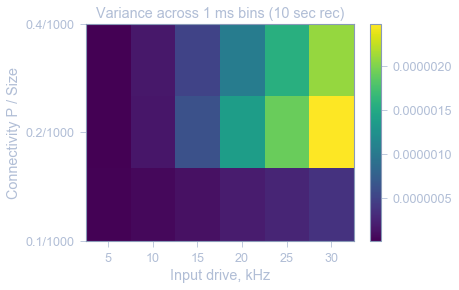

In [3]:
figure()
title('Variance across 1 ms bins (10 sec rec)')
plt.imshow(output_var/np.max(output_mean), aspect='auto')
colorbar()
yticks([-0.5, 1, 2.5], ('0.4/1000', '0.2/1000', '0.1/1000'))
xticks([0, 1, 2, 3, 4, 5], ('5', '10', '15', '20', '25', '30'))
ylabel('Connectivity P / Size')
xlabel('Input drive, kHz')

Text(0.5, 0, 'Input drive, kHz')

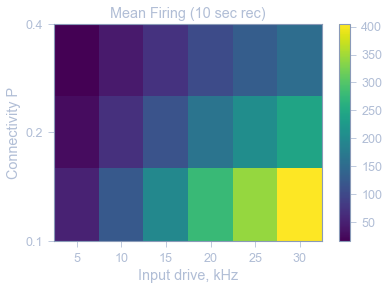

In [4]:
figure()
title('Mean Firing (10 sec rec)')
plt.imshow(output_mean, aspect='auto')
colorbar()
yticks([-0.5, 1, 2.5], ('0.4', '0.2', '0.1'))
xticks([0, 1, 2, 3, 4, 5], ('5', '10', '15', '20', '25', '30'))
ylabel('Connectivity P')
xlabel('Input drive, kHz')